In [90]:
#Import the necessary packages for analysis. 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
from numba import jit, njit
from scipy.optimize import minimize

In [75]:
#Import the two datasets as pandas dataframes
product_data_df = pd.read_csv("/Users/alextoy/Desktop/ASU PHD/Econ 753 - IO/PS1/product_data.csv")
agent_data_df = pd.read_csv("/Users/alextoy/Desktop/ASU PHD/Econ 753 - IO/PS1/agent_data.csv")

## Question 1

In [76]:
#calculate outside shares 
inside_shares_df = product_data_df.groupby(['market_ids'])['shares'].sum()
outside_shares_df = 1-inside_shares_df

outside_shares_df = pd.DataFrame(outside_shares_df)
outside_shares_df.rename(columns={'shares':'outside_share'}, inplace=True)

In [77]:
#merge outside shares into original product dataset by market id
product_data_df = pd.merge(product_data_df, outside_shares_df, on = 'market_ids')

In [78]:
#create the dependent variable for logit regressions
product_data_df['OLS_depvar'] = np.log(product_data_df['shares']) - np.log(product_data_df['outside_share'])

In [79]:
#Add a constant
product_data_df['constant'] = 1

#Define our dependent, independent, and instrumental variables
Y = product_data_df[['OLS_depvar']].to_numpy()
X = product_data_df[['constant', 'sugar','prices']].to_numpy()
Z = product_data_df[['demand_instruments0', 'demand_instruments1', 'demand_instruments2', 'demand_instruments3',\
                    'demand_instruments4','demand_instruments5','demand_instruments6','demand_instruments7',\
                    'demand_instruments8','demand_instruments9','demand_instruments10','demand_instruments11',\
                    'demand_instruments12','demand_instruments13','demand_instruments14','demand_instruments15',\
                     'demand_instruments16','demand_instruments17','demand_instruments18','demand_instruments19','prices']].to_numpy()

X_prime = X.transpose()
Z_prime = Z.transpose()


In [80]:
#OLS Estimation
X_p_X = X_prime@X
inv_XX = np.linalg.inv(X_p_X)
X_p_Y = X_prime@Y

beta_ols = inv_XX@X_p_Y
beta_ols

array([[ -2.96652562],
       [  0.04630632],
       [-10.20358686]])

In [81]:
#2SLS Estimation 
P = Z@np.linalg.inv(Z_prime@Z)@Z_prime

beta_2sls = np.linalg.inv(X_prime@P@X)@(X_prime@P@Y)
beta_2sls


array([[ -2.69219008],
       [  0.03707308],
       [-11.64724732]])

In [82]:
#Own Price Elasticities 
alpha = beta_2sls[2]

product_data_df['O_P_E'] = (product_data_df['prices']/product_data_df['shares']) * alpha * \
                ((-1)*product_data_df['shares']**2 + product_data_df['shares'])
    
#product_data_df['O_P_E'] =  alpha * product_data_df['prices']*(1 - product_data_df['shares'])

In [83]:
#Subset dataset to only C01Q1 market 
product_data_C01Q1_df = product_data_df[product_data_df['market_ids'] == 'C01Q1']

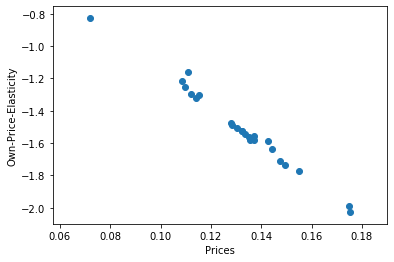

In [84]:
#scatter the data
plt.scatter(product_data_C01Q1_df['prices'], product_data_C01Q1_df['O_P_E'])
plt.xlabel("Prices")
plt.ylabel("Own-Price-Elasticity")
plt.show()

In [85]:
#Export data to check regressions in STATA
#product_data_df.to_csv(r'Post_analysis_product_data.csv')
#coefficients match those that I obtain using STATA

## Question 2

In [86]:
#rename/create variables for BLP Estimation
#create vectors as opposed to using the dataframe 

#initial delta estimate is just the logit OLS dependent variable (log(inside_j) - log(outside_t))
d_0_1 = np.ones(len(Y))

#create a vector of prices 
price = product_data_df['prices'].to_numpy()

#shares
shares = product_data_df[['shares']].to_numpy()

#income
income = agent_data_df[['income']].to_numpy()

#create the standard normal distributions of v, the random preference component of price
v = agent_data_df[['nodes0']].to_numpy()

In [87]:
#initialize parameters for test code 
b_income = 0
b_sugar = 0
a_income = 0
a_v = -20
constant = product_data_df[['constant']].to_numpy()
sugar = product_data_df[['sugar']].to_numpy()
price = product_data_df[['prices']].to_numpy()

### Fun with Functions!

I''ll be using the following function to calulate utility and subsequently shares
$$
\frac{1}{ns} \sum_{ns} \frac{exp\left(\delta_{jt} + \sum_k x_{jt}^k(\sigma_k\nu_i^k + \pi_{kl}D_{il} + ... +\pi_{kd}D_{id} \right)}{1 +\sum_m exp\left(\delta_{mt} + \sum_k x_{mt}^k(\sigma_k\nu_i^k + \pi_{kl}D_{il} + ... +\pi_{kd}D_{id} \right)}
$$

In [91]:
@njit
def pred_shares_mat(delta, constant, b_income, b_sugar, a_income, a_v, income, sugar, price, v):
    #shape data into matrices from vectors
    delta = np.reshape(delta,(94,24))
    income = np.reshape(income,(94,20))
    v = np.reshape(v, (94,20))
    price = np.reshape(price,(94,24))
    constant = np.reshape(constant, (94,24))
    sugar = np.reshape(sugar, (94,24))
    #initialize utility 
    utility = np.zeros((24,20,94))
    #calculate utility for every person for every good in every market 
    for market in range(94):
        for person in range(20):
            for good in range(24):
                utility[good,person,market] = delta[market,good] +\
                                        constant[market,good]*b_income*income[market,person] + \
                                                         b_sugar*income[market,person]*sugar[market,good] +\
                                                         a_income*income[market,person]*price[market,good] +\
                                                         a_v*v[market,person]*price[market,good]
            
    #exponential of indirect utility       
    num = np.exp(utility) 
    #create the denominator of the function by summing across goods for every person
    denom = 1+ np.sum(num, axis = 0)
    #create the logit term
    n_over_d = np.zeros((24,20,94))
    for market in range(94):
        for person in range(20):
            for good in range(24):
                n_over_d[good,person,market] = num[good,person,market] / denom[person,market]
    #create unweighted shares by summing across person for every good
    unweighted_shares = np.sum(n_over_d, axis = 1).T
    #weight shares
    weighted_shares = unweighted_shares*.05
    return weighted_shares
#check for function success
pred_shares1 = pred_shares_mat(d_0_1, constant, b_income, b_sugar, a_income, a_v, income, sugar, price, v)
np.sum(pred_shares1)

87.21731159886002

In [111]:
@njit
def delta_loop(shares, delta, constant, b_income, b_sugar, a_income, a_v, income, sugar, price, v):
    #difference between initial and computed delta just need to initialize greater than tolerance
    #to start while loop
    largest_diff = 10
    #tolerance as outlined in lecture notes/Nevo appendix
    tol = 10e-12
    #keep track of iterations if wanted
    num_iter = 0
    #reshape inputs into matrix rows = markets, columns = goods
    shares = np.reshape(shares, (94,24))
    delta = np.reshape(delta, (94,24))
    #Iterate the contraction mapping as shown in Step 2 of Nevo's appendix
    while largest_diff > tol:
        #start_time = time.time()
        #step 1: get the predictions
        pred_share = pred_shares_mat(delta, constant, b_income, b_sugar, a_income, a_v, income, sugar, price, v)
        #step 2: calculate new delta
        delta_new = delta + np.log(shares) - np.log(pred_share)
        #get the difference between initial delta and new predicted delta 
        #take the maximum absolute difference between every initial and predicted delta
        largest_diff = np.max(np.abs(delta - delta_new))
        #set initial delta as new delta and iterate through until convergence 
        delta = delta_new
        num_iter+=1
        #print statement for testing
        #print(num_iter, largest_diff)
    #end_time = time.time()
    #print statement for testing time
    #print("total time taken this loop: ", end_time - start_time)
    return delta
#check for functionality    
#delta = delta_loop(shares,d_0_1,constant, 6.29712762, 0.1524712, -46.16895562, 1.04088262, income, sugar, price, v)
#pd.DataFrame(np.reshape(delta, (-1,1))).head(25)


,0
0,-5.230748
1,-6.252891
2,-3.743177
3,-4.548272
4,-3.454750
5,-3.514779
6,-3.103265
7,-4.716245
8,-4.827420
9,-2.819589


In [133]:
#Now for GMM
#define optimal weighting matrix 
Z = product_data_df[['sugar', 'demand_instruments0', 'demand_instruments1', 'demand_instruments2', 'demand_instruments3',\
                    'demand_instruments4','demand_instruments5','demand_instruments6','demand_instruments7',\
                    'demand_instruments8','demand_instruments9','demand_instruments10','demand_instruments11',\
                    'demand_instruments12','demand_instruments13','demand_instruments14','demand_instruments15',\
                     'demand_instruments16','demand_instruments17','demand_instruments18','demand_instruments19']].to_numpy()

weight = np.linalg.inv(Z.T @ Z)

#initial guesses
#initial guess based on Nacho/Jacob's 100 iterations
theta = [0,0,0,0,0,0]
theta = np.asarray(theta)
#initial guess of delta that imediately iterates solve_delta for guess
delta = delta
theta_4 = [ -4.21157897e+00,  5.27327279e+00,  1.44415318e-01,  1.47881559e-02, -3.78233741e+01,  1.18306888e+00]
theta_4 = np.asarray(theta_4)
#initial guess based on Nico's solution
theta_nico = [-1.90671652653057,4.86198134077309,0.154992993323169,-1.52500599007840,-37.2010173980647,1.04623710245764]
theta_nico = np.asarray(theta_nico)


In [134]:
#define our GMM objective function 
def obj(theta, Z, weight,shares, delta, constant, income, sugar, price, v):
    #set parameters based on theta input
    #theta is the initial guess and what is minimized over
    b_0 = theta[0]
    b_income = theta[1]
    b_sugar = theta[2]
    a_0 = theta[3]
    a_income = theta[4]
    a_v = theta[5]
    
    #solve for mean utility delta based on input theta and initial delta
    delta = delta_loop(shares, delta, constant, b_income, b_sugar, a_income, a_v, income, sugar, price, v)
    #take solved delta and calculate unobserved shocks based on formula from lecture notes
    xi =  np.reshape(delta,(-1,1)) - b_0*constant - a_0*price
    
    #define the objective function over which we'll minimize
    theta_hat = xi.T @ Z @ weight @ Z.T @ xi
    #print the objective function value and parameters 
    #this is so we can visually see our minimization in progress
    print(theta_hat, theta)
    return theta_hat

In [135]:
parameters = minimize(obj, theta_4, args = (Z, weight,shares, delta, constant, income, sugar, price, v), method = 'Nelder-Mead')

[[136.06719106]] [-4.21157897e+00  5.27327279e+00  1.44415318e-01  1.47881559e-02
 -3.78233741e+01  1.18306888e+00]
[[239.44828189]] [-4.42215792e+00  5.27327279e+00  1.44415318e-01  1.47881559e-02
 -3.78233741e+01  1.18306888e+00]
[[145.34212284]] [-4.21157897e+00  5.53693643e+00  1.44415318e-01  1.47881559e-02
 -3.78233741e+01  1.18306888e+00]
[[137.96779743]] [-4.21157897e+00  5.27327279e+00  1.51636084e-01  1.47881559e-02
 -3.78233741e+01  1.18306888e+00]
[[136.0678698]] [-4.21157897e+00  5.27327279e+00  1.44415318e-01  1.55275637e-02
 -3.78233741e+01  1.18306888e+00]
[[145.98816936]] [-4.21157897e+00  5.27327279e+00  1.44415318e-01  1.47881559e-02
 -3.97145428e+01  1.18306888e+00]
[[136.0599477]] [-4.21157897e+00  5.27327279e+00  1.44415318e-01  1.47881559e-02
 -3.78233741e+01  1.24222232e+00]
[[238.81054934]] [-4.00100002e+00  5.36116067e+00  1.46822240e-01  1.50346252e-02
 -3.84537637e+01  1.20278669e+00]
[[161.57653566]] [-4.10628950e+00  5.33918870e+00  1.46220509e-01  1.49730

[[135.15774699]] [-4.23148701e+00  5.57757791e+00  1.46924512e-01  1.18386671e-02
 -4.02223530e+01  1.31338103e+00]
[[135.08627725]] [-4.23738893e+00  5.66063032e+00  1.47273525e-01  1.09862301e-02
 -4.08276450e+01  1.35095798e+00]
[[135.14371338]] [-4.23519457e+00  5.58919728e+00  1.46634158e-01  1.18925338e-02
 -4.03289097e+01  1.29715983e+00]
[[135.21186139]] [-4.23751083e+00  5.65197243e+00  1.46994497e-01  1.10969096e-02
 -4.06540947e+01  1.30289568e+00]
[[135.08085245]] [-4.23923614e+00  5.68691804e+00  1.48001466e-01  1.12763868e-02
 -4.10699065e+01  1.30811284e+00]
[[135.11191272]] [-4.24616553e+00  5.79360867e+00  1.49098827e-01  1.06381286e-02
 -4.19123883e+01  1.32166879e+00]
[[134.99377915]] [-4.24041789e+00  5.70688789e+00  1.47584367e-01  1.06195292e-02
 -4.12564640e+01  1.32474211e+00]
[[134.9605505]] [-4.24664897e+00  5.80437948e+00  1.48042427e-01  9.56608523e-03
 -4.20515631e+01  1.34945967e+00]
[[135.01980831]] [-4.24014132e+00  5.76011875e+00  1.46363385e-01  1.0606

[[134.92879169]] [-4.24639974e+00  5.79790278e+00  1.47661251e-01  1.01548863e-02
 -4.20527821e+01  1.30925538e+00]
[[134.92831878]] [-4.24336356e+00  5.76991058e+00  1.46905475e-01  1.05803997e-02
 -4.17852867e+01  1.30584747e+00]
[[134.92476095]] [-4.24474113e+00  5.78380250e+00  1.47049053e-01  1.05277449e-02
 -4.19183731e+01  1.29226209e+00]
[[134.92280221]] [-4.24468117e+00  5.78380565e+00  1.47049367e-01  1.07074814e-02
 -4.19279428e+01  1.27781820e+00]
[[134.92466046]] [-4.24626278e+00  5.79297151e+00  1.47388733e-01  1.05115950e-02
 -4.20074565e+01  1.29646463e+00]
[[134.92492462]] [-4.24509576e+00  5.77932236e+00  1.47423152e-01  1.06080923e-02
 -4.19244533e+01  1.29147658e+00]
[[134.92275669]] [-4.24526498e+00  5.78472287e+00  1.47084720e-01  1.04731128e-02
 -4.19145640e+01  1.29075264e+00]
[[134.92238999]] [-4.24537505e+00  5.78500504e+00  1.46978475e-01  1.04735719e-02
 -4.18986502e+01  1.28383630e+00]
[[134.92415781]] [-4.24761674e+00  5.80400229e+00  1.47500788e-01  1.032

[[134.90888395]] [-4.24584268e+00  5.78575710e+00  1.47450043e-01  1.12877338e-02
 -4.19769257e+01  1.18537093e+00]
[[134.90959323]] [-4.24561797e+00  5.78492375e+00  1.47494513e-01  1.15215995e-02
 -4.19821190e+01  1.17182415e+00]
[[134.90921243]] [-4.24625077e+00  5.78745325e+00  1.47554869e-01  1.14989461e-02
 -4.19920430e+01  1.18205928e+00]
[[134.90892425]] [-4.24558233e+00  5.78203692e+00  1.47503075e-01  1.15031930e-02
 -4.19497093e+01  1.17712516e+00]
[[134.90925006]] [-4.24575304e+00  5.78271189e+00  1.47511609e-01  1.14110648e-02
 -4.19534687e+01  1.19639903e+00]
[[134.90885229]] [-4.24605659e+00  5.78752705e+00  1.47529809e-01  1.12707367e-02
 -4.19912004e+01  1.19189523e+00]
[[134.9088927]] [-4.24619422e+00  5.78987312e+00  1.47534331e-01  1.10863951e-02
 -4.20072422e+01  1.19961369e+00]
[[134.90882145]] [-4.24568777e+00  5.78002335e+00  1.47566547e-01  1.14256958e-02
 -4.19396182e+01  1.18467592e+00]
[[134.90900079]] [-4.24546828e+00  5.77521717e+00  1.47602083e-01  1.1423

[[134.89170349]] [-4.24371919e+00  5.76689274e+00  1.46862783e-01 -1.55192709e-03
 -4.17613837e+01  1.24626273e+00]
[[134.89032141]] [-4.24259648e+00  5.75061758e+00  1.47096166e-01  1.06654860e-04
 -4.16635221e+01  1.23940003e+00]
[[134.89175489]] [-4.24203441e+00  5.74006680e+00  1.47249221e-01  5.66291314e-04
 -4.15951467e+01  1.22490528e+00]
[[134.88865381]] [-4.24285893e+00  5.76320965e+00  1.46733583e-01 -1.86528004e-03
 -4.17382315e+01  1.24411557e+00]
[[134.88833655]] [-4.24266702e+00  5.76631463e+00  1.46531114e-01 -3.24599574e-03
 -4.17523208e+01  1.23737061e+00]
[[134.88997639]] [-4.24129447e+00  5.74731847e+00  1.46476006e-01 -3.43532282e-03
 -4.15960171e+01  1.22642145e+00]
[[134.88890516]] [-4.24103922e+00  5.74514778e+00  1.46664148e-01 -1.47304764e-03
 -4.16067920e+01  1.23936233e+00]
[[134.88616331]] [-4.24091809e+00  5.74439367e+00  1.46632365e-01 -3.71322435e-03
 -4.15856739e+01  1.24753831e+00]
[[134.8845215]] [-4.23980711e+00  5.73557946e+00  1.46530067e-01 -5.6437

[[133.24919254]] [ -4.02463993   5.3784252    0.14897033  -1.39749083 -39.98949225
   1.45943096]
[[133.0397048]] [ -4.0064212    5.30355161   0.14865724  -1.50061762 -39.41974179
   1.49479383]
[[132.89070375]] [ -3.96489095   5.22287166   0.14912533  -1.77358869 -38.99539121
   1.43852257]
[[132.98843227]] [ -4.07545713   5.48575069   0.1478668   -1.1059822  -40.44968838
   1.50722328]
[[132.99547759]] [ -4.06814384   5.4216447    0.1499416   -1.11384468 -40.12230192
   1.24392858]
[[132.8273362]] [ -4.00768516   5.33691242   0.14737492  -1.49463269 -39.54539496
   1.25974979]
[[132.88725437]] [ -3.96936262   5.28201419   0.14626618  -1.73471373 -39.18349509
   1.08714096]
[[132.86305561]] [ -3.96184099   5.2758911    0.14995086  -1.81974256 -39.45626061
   1.27284884]
[[132.54969973]] [ -4.01582019   5.32831363   0.14841345  -1.45368104 -39.44412
   1.2600626 ]
[[132.3778012]] [ -4.01141032   5.30325784   0.14813501  -1.48177615 -39.17143388
   1.16037842]
[[132.28918221]] [ -3.9864

[[130.60142685]] [ -3.80760201   4.85245181   0.15621618  -3.0960762  -37.25886533
   0.98110711]
[[130.63729639]] [ -3.80293947   4.84266116   0.15392783  -3.07409207 -36.98353405
   1.00574633]
[[130.59271076]] [ -3.81092942   4.87629044   0.15572986  -3.09722608 -37.35356907
   1.06439777]
[[130.6131589]] [ -3.82947772   4.95706205   0.15573241  -2.99629306 -37.95416863
   0.96433623]
[[130.58815774]] [ -3.80213685   4.83843834   0.1550533   -3.1200924  -37.02711858
   1.07367272]
[[130.61772467]] [ -3.80177151   4.86216756   0.15595263  -3.15011635 -37.31809028
   1.17568285]
[[130.58740325]] [ -3.81250384   4.87550685   0.15502693  -3.06428516 -37.28383369
   1.00079337]
[[130.62086442]] [ -3.81188474   4.89735403   0.15405839  -3.0791179  -37.33996257
   1.1436347 ]
[[130.58613585]] [ -3.80867269   4.86367737   0.15567673  -3.09183662 -37.27913964
   1.02173901]
[[130.58511714]] [ -3.81226476   4.83292905   0.15469362  -3.03798507 -36.93001211
   1.06651865]
[[130.60463027]] [ -3

[[130.57985022]] [ -3.81374026   4.86287445   0.15500743  -3.04826847 -37.20867958
   1.04695234]
[[130.57984463]] [ -3.81352839   4.86214468   0.15500449  -3.04957284 -37.20257356
   1.045453  ]
[[130.57985815]] [ -3.81331928   4.86102699   0.15501227  -3.050901   -37.19498897
   1.04392975]
[[130.57985671]] [ -3.81361607   4.86196845   0.15495475  -3.04788951 -37.19748631
   1.0473579 ]
[[130.57985929]] [ -3.81350419   4.86288308   0.15500448  -3.05061489 -37.20824032
   1.04785044]
[[130.57984766]] [ -3.81358318   4.86285511   0.15499686  -3.04960133 -37.20733787
   1.04743833]
[[130.57987208]] [ -3.8136973    4.86398137   0.15503775  -3.04985664 -37.21866836
   1.04672133]
[[130.57984569]] [ -3.81363638   4.86247168   0.1549755   -3.04838129 -37.20278182
   1.04719876]
[[130.5798672]] [ -3.81400903   4.86444348   0.15501593  -3.04718201 -37.2210353
   1.0428572 ]
[[130.57984622]] [ -3.81354277   4.86242163   0.15498621  -3.04930933 -37.20303506
   1.04837646]
[[130.57985392]] [ -3.

[[130.57984167]] [ -3.81344517   4.86199241   0.15499361  -3.04996118 -37.20110594
   1.04625107]
[[130.57984164]] [ -3.81344659   4.86199002   0.15499235  -3.04990326 -37.20101838
   1.0462381 ]
[[130.57984166]] [ -3.81344947   4.86202867   0.15499158  -3.04989302 -37.20123556
   1.04625807]
[[130.57984164]] [ -3.81344516   4.86197884   0.15499306  -3.04992818 -37.20098335
   1.04623673]
[[130.57984164]] [ -3.81344579   4.86199397   0.15499317  -3.04992796 -37.20109195
   1.04621197]
[[130.57984164]] [ -3.81344528   4.86199476   0.15499364  -3.04993655 -37.20112393
   1.04618498]
[[130.57984166]] [ -3.81345862   4.86200446   0.15499279  -3.04981548 -37.20111858
   1.04620917]
[[130.57984164]] [ -3.81344237   4.86198981   0.15499276  -3.04995344 -37.20104766
   1.04624322]
[[130.57984164]] [ -3.81344527   4.86199025   0.1549926   -3.04992553 -37.20099577
   1.0462815 ]
[[130.57984164]] [ -3.81343922   4.86196093   0.15499263  -3.04995807 -37.20082604
   1.04618965]
[[130.57984164]] [ -

In [136]:
parameters

 final_simplex: (array([[ -3.81343728,   4.86198634,   0.15499321,  -3.04999126,
        -37.20108419,   1.04622829],
       [ -3.81344042,   4.86198697,   0.15499259,  -3.04995857,
        -37.20100294,   1.04623342],
       [ -3.81343905,   4.86198369,   0.15499274,  -3.04996882,
        -37.200992  ,   1.04628683],
       [ -3.81344289,   4.86198732,   0.1549931 ,  -3.04994086,
        -37.20105384,   1.04622252],
       [ -3.81344154,   4.86199234,   0.15499326,  -3.0499618 ,
        -37.20108293,   1.04624965],
       [ -3.81343937,   4.86197656,   0.15499316,  -3.04997158,
        -37.20099341,   1.0462475 ],
       [ -3.81344488,   4.86200039,   0.15499291,  -3.04993616,
        -37.20112093,   1.04626873]]), array([130.57984163, 130.57984163, 130.57984163, 130.57984163,
       130.57984163, 130.57984164, 130.57984164]))
           fun: 130.57984163421145
       message: 'Optimization terminated successfully.'
          nfev: 660
           nit: 416
        status: 0
       succ